# Simulated Quad Scan

This will show a simple 'simulation' of a quadrupole scan of a beam to a screen.

This assumes that the system consists of a thick quadrupole maget followed by an uncoupled linear transport map that the user provides. Here we will just use a 2.2 m long drift.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs

Load this config and add a drift.

In [3]:
CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

{'name': 'LCLS2',
 'species': 'electron',
 'Lquad': 0.1244,
 'energy': 80000000.0,
 'Twiss0': [1e-06, 1e-06, 5.01, 5.01, 0.049, 0.049],
 'rMatx': [1, 2.2, 0, 1],
 'rMaty': [1, 2.2, 0, 1]}

# Simulation

In [4]:
from pyemittance.simulation import BeamSim

In [5]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}

Create the simulation

In [6]:
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])

In [7]:
sim.screen_sigma('x'), sim.screen_sigma('y')

(0.000316975039076531, 0.0005391478973939177)

 Set the scanning quadrupole (in machine units) and get the x and y beam sizes

In [8]:
sim.quad_value = 2
sim.screen_beam_sizes()

(0.00012627736478842047, 0.0011887442162668135)

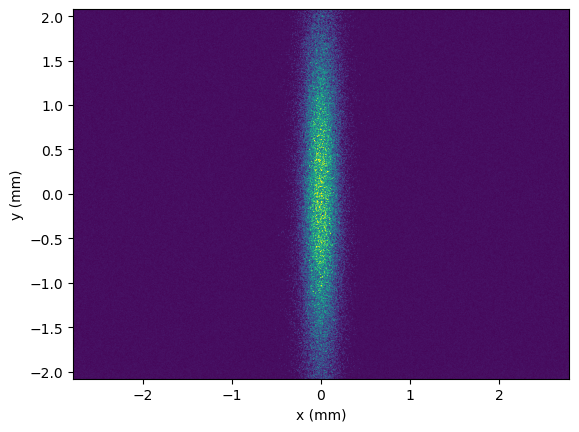

In [9]:
sim.plot_screen()

Set the noise level. This just adds random numbers with a maximum value of this level.

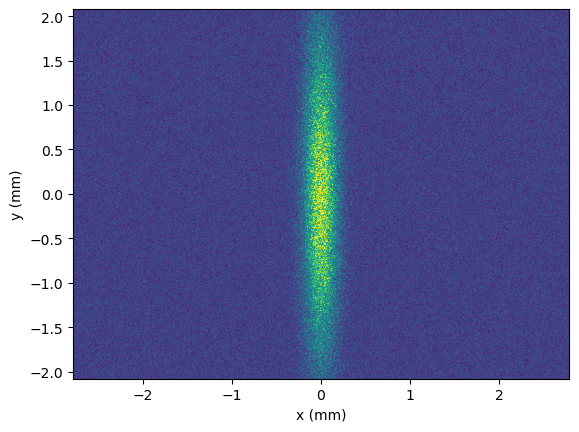

In [10]:
sim.screen.noise=50
sim.plot_screen()

Simple interaction

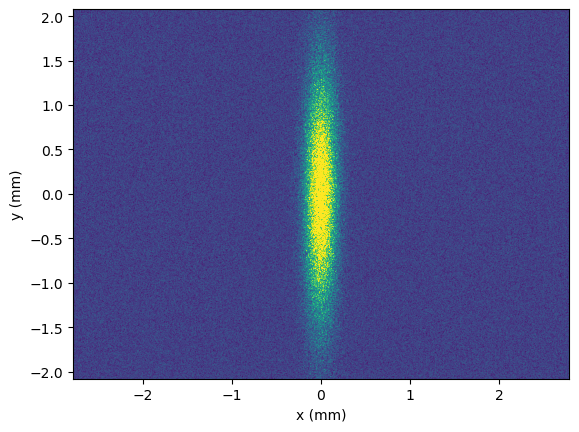

In [11]:
from ipywidgets import interact

def f(quad_value):
    sim.quad_value = quad_value
    sim.plot_screen()
  
f(1)

# interact(f, quad_value=(-4, 4, .1), vmax=128)

# Measurements

## Make the data

In [12]:
quad_vals = np.linspace(-2,2, 20)
meas =  np.array([sim.beam_size_meas(v) for v in quad_vals])
meas_x = meas[:,0]
meas_y = meas[:,1]

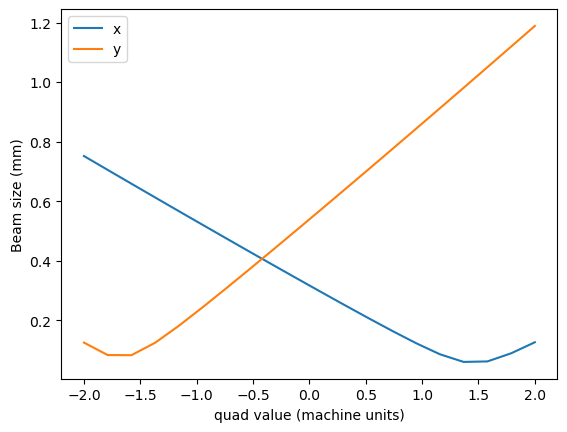

In [13]:
plt.plot(quad_vals, meas_x*1e3, label='x')
plt.plot(quad_vals, meas_y*1e3, label='y')
plt.xlabel('quad value (machine units)')
plt.ylabel('Beam size (mm)')
plt.legend()

# Emittance calculation

(9.999999999999995e-07,
 2.0000000000000046e-06,
 10.0,
 10.99999999999998,
 -1.0,
 -1.9999999999999951)

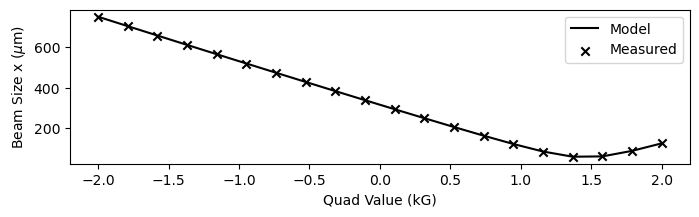

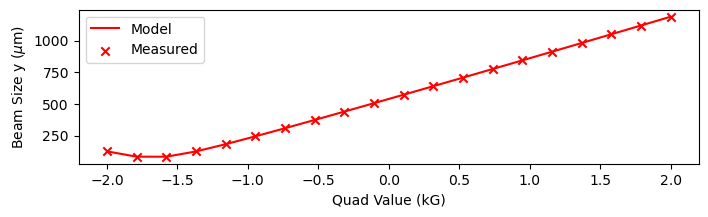

In [14]:
ef = EmitCalc({'x': quad_vals,'y': quad_vals},
              {'x': meas_x ,'y': meas_y},
              {'x': meas_x*0.03 ,'y': meas_y*0.03},
              config_dict=CONFIG,
             )

ef.plot = True             
result = ef.get_emit()

result['norm_emit_x'], result['norm_emit_y'], result['beta_x'], result['beta_y'], result['alpha_x'], result['alpha_y']

In [15]:
print(ef.summary())

"
    Emittance Calculation Summary
    
    Emittance x: 1.000 +/- 0.022 mm mrad
    Emittance y: 2.000 +/- 0.046 mm mrad
    
    Before scanning quad:
                    x        y
    norm_emit      1.00      2.00 (mm-mrad)                    
    beta          10.00     11.00 (m)
    alpha         -1.00     -2.00 (1)

    
    


# Image Analysis

PyEmittance has its own image analysis tools. Let's check these.

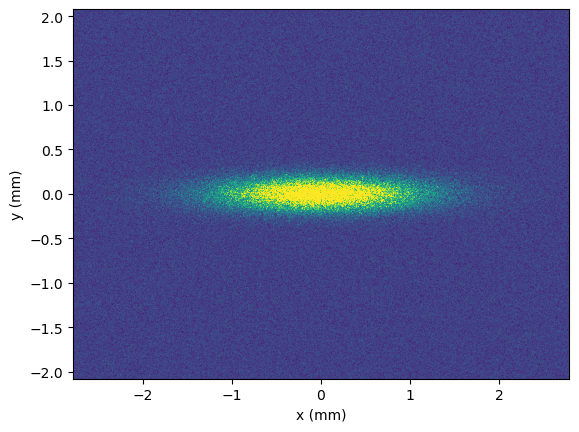

In [16]:
sim.quad_value = -2
sim.plot_screen()

Get a raw image. Note that images are always (row, column), in image coordinates (0,0) is in the top left).

In [17]:
im = sim.screen_image()
im.shape

(1040, 1392)

These are the true beam sizes

In [18]:
sim_sigma_x, sim_sigma_y = sim.screen_beam_sizes()

In [19]:
from pyemittance.image import Image

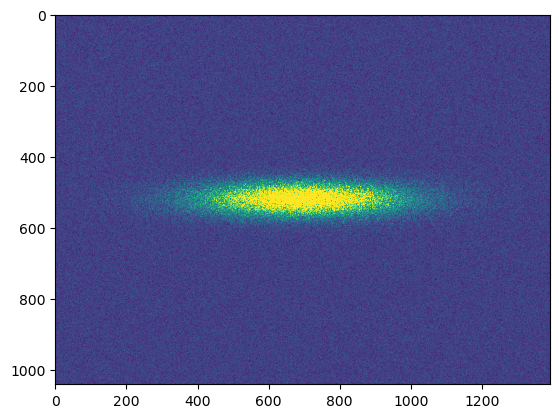

In [20]:
raw_im = sim.screen_image()
im = Image(raw_im,  sim.screen.nrow, sim.screen.ncol)
im.reshape_im()
plt.imshow(im.proc_image, vmax=128)

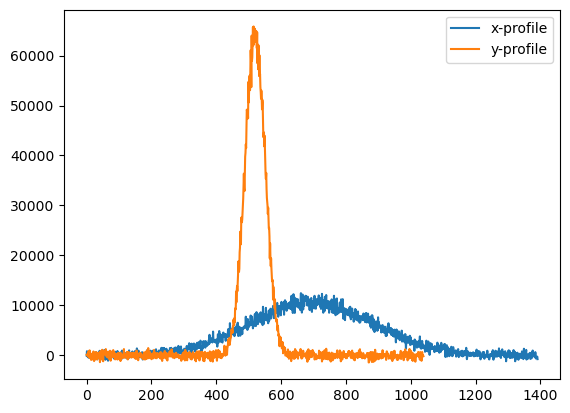

In [21]:
profx, profy = im.get_im_projection()
plt.plot(profx, label="x-profile")
plt.plot(profy, label="y-profile")
plt.legend()

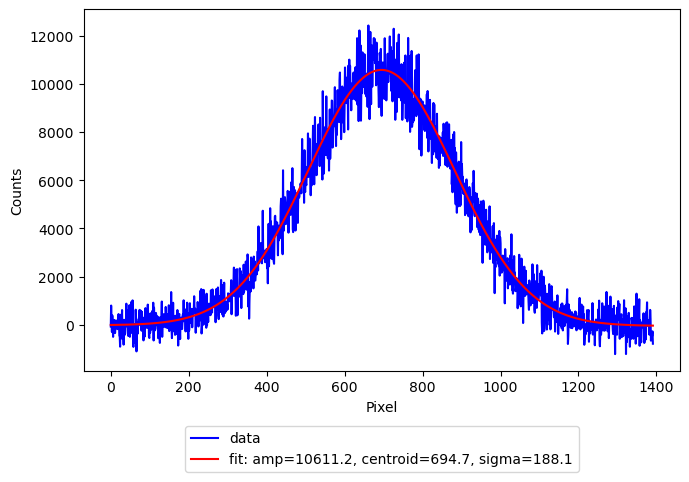

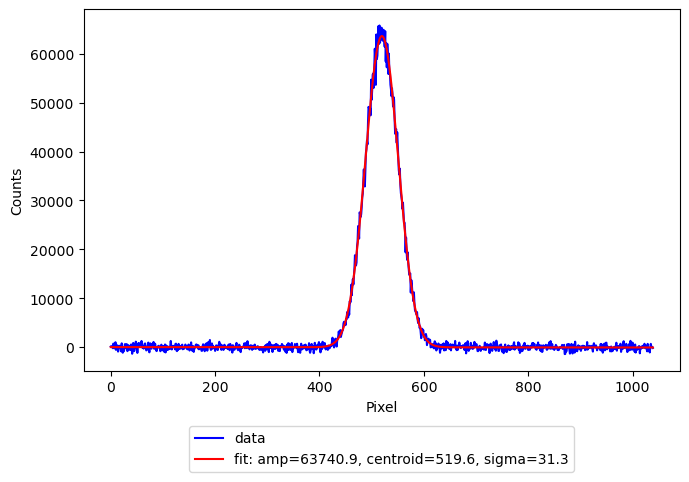

In [22]:
fit_res = im.get_sizes(method = "gaussian", show_plots = True)
xsize, ysize, xsize_error, ysize_error, x_amplitude, y_amplitude = fit_res

In [23]:
sim_sigma_x, sim_sigma_y = sim.screen_beam_sizes()
resolution = sim.screen.resolution

meas_sigma_x = xsize * resolution
meas_sigma_y = ysize * resolution

These agree fairly well:

In [24]:
meas_sigma_x/sim_sigma_x

1.0005703025910728

In [25]:
meas_sigma_y/sim_sigma_y

1.000599958804349

In [26]:
im.proc_image

array([[ 8, 30,  3, ..., 49, 25, 33],
       [ 2, 11, 42, ..., 13, 45, 37],
       [26, 39, 41, ..., 13, 46, 29],
       ...,
       [15, 37, 40, ..., 14, 31, 21],
       [48, 46,  1, ...,  5, 23, 29],
       [ 2, 15, 12, ..., 13, 44, 33]], dtype=int16)